In [5]:
# globals
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np
# scipy library
from scipy.stats import chi2_contingency, mannwhitneyu, shapiro
# imblern library
from imblearn.pipeline import Pipeline as imPipeline
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
# statsmodels library
from statsmodels.stats.outliers_influence import variance_inflation_factor
# sklearn library
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score, f1_score
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

In [6]:
# Load each dataset
vle = pd.read_csv("data/vle.csv")
student_info = pd.read_csv("data/studentInfo.csv")
student_registration = pd.read_csv("data/studentRegistration.csv")
student_vle = pd.read_csv("data/studentVle.csv")
courses = pd.read_csv("data/courses.csv")

# Data Cleaning and preparation

## Missing Values

In [7]:
# Check for missing values and handle them if necessary
print("Missing values:\n", vle.isnull().sum())
print("Missing values:\n", student_info.isnull().sum())
print("Missing values:\n", student_registration.isnull().sum())
print("Missing values:\n", student_vle.isnull().sum())
print("Missing values:\n", courses.isnull().sum())

Missing values:
 id_site                 0
code_module             0
code_presentation       0
activity_type           0
week_from            5243
week_to              5243
dtype: int64
Missing values:
 code_module                0
code_presentation          0
id_student                 0
gender                     0
region                     0
highest_education          0
imd_band                1111
age_band                   0
num_of_prev_attempts       0
studied_credits            0
disability                 0
final_result               0
dtype: int64
Missing values:
 code_module                0
code_presentation          0
id_student                 0
date_registration         45
date_unregistration    22521
dtype: int64
Missing values:
 code_module          0
code_presentation    0
id_student           0
id_site              0
date                 0
sum_click            0
dtype: int64
Missing values:
 code_module                   0
code_presentation             0
module_prese

In [8]:
# Drop 'week_from' and 'week_to' columns
vle = vle.drop(['week_from', 'week_to'], axis=1)

# Remove rows where 'date_registration' is missing
student_registration = student_registration.dropna(subset=['date_registration'])

# Drop 'date_unregistration' column
student_registration = student_registration.drop(['date_unregistration'], axis=1)

# Filling the missing values in 'imd_band' with the mode of 'imd_band' for each region
for region in student_info['region'].unique():
    mode_imd = student_info[student_info['region'] == region]['imd_band'].mode().iloc[0]
    student_info.loc[student_info['region'] == region, 'imd_band'] = student_info.loc[student_info['region'] == region, 'imd_band'].fillna(mode_imd)

print("Missing values after imputation:\n", student_info.isnull().sum())
print("Missing values after imputation:\n", student_registration.isnull().sum())
print("Missing values after imputation:\n", vle.isnull().sum())

Missing values after imputation:
 code_module             0
code_presentation       0
id_student              0
gender                  0
region                  0
highest_education       0
imd_band                0
age_band                0
num_of_prev_attempts    0
studied_credits         0
disability              0
final_result            0
dtype: int64
Missing values after imputation:
 code_module          0
code_presentation    0
id_student           0
date_registration    0
dtype: int64
Missing values after imputation:
 id_site              0
code_module          0
code_presentation    0
activity_type        0
dtype: int64


## Feature Engineering 

In [9]:
vle.columns

Index(['id_site', 'code_module', 'code_presentation', 'activity_type'], dtype='object')

In [10]:
student_vle.columns

Index(['code_module', 'code_presentation', 'id_student', 'id_site', 'date',
       'sum_click'],
      dtype='object')

In [11]:
# Merge on multiple keys
vle_merged = student_vle.merge(vle, on=['id_site', 'code_module', 'code_presentation'])

In [12]:
vle_merged.columns

Index(['code_module', 'code_presentation', 'id_student', 'id_site', 'date',
       'sum_click', 'activity_type'],
      dtype='object')

In [13]:
# Calculate the sum of clicks for each student within 14 days of the start of the module-presentation
N = 14  # N representating the number of days
early_engagement = vle_merged[vle_merged['date'] <= N].groupby('id_student')['sum_click'].sum().reset_index()

# Rename the column to early_engagement
early_engagement.rename(columns={'sum_click': 'early_engagement'}, inplace=True)

# Merge early_engagement back to the original DataFrame
vle_merged = pd.merge(vle_merged.drop_duplicates(subset='id_student'), early_engagement, on='id_student', how='left')

# Fill missing values with 0
vle_merged['early_engagement'] = vle_merged['early_engagement'].fillna(0)

vle_merged.early_engagement

0        456.0
1        281.0
2        349.0
3        472.0
4        568.0
         ...  
26069      0.0
26070      0.0
26071      0.0
26072      0.0
26073      0.0
Name: early_engagement, Length: 26074, dtype: float64

In [14]:
# Calculate the most frequent activity for each student in the first 14 days
N = 14  # 14 days
most_freq_activity = vle_merged[vle_merged['date'] <= N].groupby(['id_student', 'activity_type']).size().reset_index(name='counts')

# Find the activity with the most frequency for each student
most_freq_activity = most_freq_activity.loc[most_freq_activity.groupby('id_student')['counts'].idxmax()]

# Drop the 'counts' column as it's not needed anymore
most_freq_activity.drop('counts', axis=1, inplace=True)

# Rename the column to 'most_freq_activity'
most_freq_activity.rename(columns={'activity_type': 'most_freq_activity'}, inplace=True)

# Merge 'most_freq_activity' back to the original DataFrame
vle_merged = pd.merge(vle_merged.drop_duplicates(subset='id_student'), most_freq_activity, on='id_student', how='left')

vle_merged

,code_module,code_presentation,id_student,id_site,date,sum_click,activity_type,early_engagement,most_freq_activity
0,AAA,2013J,28400,546652,-10,4,forumng,456.0,forumng
1,AAA,2013J,30268,546652,-10,3,forumng,281.0,forumng
2,AAA,2013J,31604,546672,-10,1,oucontent,349.0,oucontent
3,AAA,2013J,32885,546681,-10,5,oucontent,472.0,oucontent
4,AAA,2013J,38053,546879,-10,7,subpage,568.0,subpage
...,...,...,...,...,...,...,...,...,...
26069,GGG,2014J,645598,896971,91,1,oucontent,0.0,NaN
26070,GGG,2014J,627809,896943,99,1,homepage,0.0,NaN
26071,GGG,2014J,676034,897063,123,1,resource,0.0,NaN
26072,GGG,2014J,121182,896943,123,1,homepage,0.0,NaN


## Merge

In [15]:
# Merge the dataframes
df = pd.merge(student_info, student_registration, on=['code_module', 'code_presentation', 'id_student'], how='outer')
df = pd.merge(df, vle_merged, on=['code_module', 'code_presentation', 'id_student'], how='outer')
df = pd.merge(df, courses, on=['code_module', 'code_presentation'], how='outer')

df

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,date_registration,id_site,date,sum_click,activity_type,early_engagement,most_freq_activity,module_presentation_length
0,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass,-159.0,546669.0,-5.0,16.0,oucontent,301.0,oucontent,268
1,AAA,2013J,28400,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,Pass,-53.0,546652.0,-10.0,4.0,forumng,456.0,forumng,268
2,AAA,2013J,30268,F,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,Y,Withdrawn,-92.0,546652.0,-10.0,3.0,forumng,281.0,forumng,268
3,AAA,2013J,31604,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,Pass,-52.0,546672.0,-10.0,1.0,oucontent,349.0,oucontent,268
4,AAA,2013J,32885,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,Pass,-176.0,546681.0,-10.0,5.0,oucontent,472.0,oucontent,268
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32588,GGG,2014J,2640965,F,Wales,Lower Than A Level,10-20,0-35,0,30,N,Fail,-4.0,896943.0,-4.0,2.0,homepage,19.0,homepage,269
32589,GGG,2014J,2645731,F,East Anglian Region,Lower Than A Level,40-50%,35-55,0,30,N,Distinction,-23.0,897083.0,19.0,1.0,resource,0.0,NaN,269
32590,GGG,2014J,2648187,F,South Region,A Level or Equivalent,20-30%,0-35,0,30,Y,Pass,-129.0,897071.0,-10.0,1.0,resource,24.0,resource,269
32591,GGG,2014J,2679821,F,South East Region,Lower Than A Level,90-100%,35-55,0,30,N,Withdrawn,-49.0,896939.0,-14.0,3.0,forumng,69.0,forumng,269


In [16]:
df = df.drop(['id_site', 'id_student', 'activity_type' , 'sum_click', 'date'], axis=1)

In [17]:
df['num_of_prev_attempts'] = df['num_of_prev_attempts'].astype('category')
df['module_presentation_length'] = df['module_presentation_length'].astype('category')

In [18]:
df['withdrawn'] = df['final_result'].apply(lambda x: 1 if x == 'Withdrawn' else 0)
print("Unique values in 'Withdrawn':", df['withdrawn'].unique())
print("Counts of unique values in 'Withdrawn':\n", df['withdrawn'].value_counts())

Unique values in 'Withdrawn': [0 1]
Counts of unique values in 'Withdrawn':
 withdrawn
0    22437
1    10156
Name: count, dtype: int64


In [19]:
# Fill missing values with 0 and NULL to represent the absense of activity by certain students
df['most_freq_activity'] = df['most_freq_activity'].fillna('NULL')
df['early_engagement'] = df['early_engagement'].fillna(0)

# Remove rows where 'date_registration' is missing
df = df.dropna(subset=['date_registration'])

print("Missing values after imputation:\n", df.isnull().sum())

Missing values after imputation:
 code_module                   0
code_presentation             0
gender                        0
region                        0
highest_education             0
imd_band                      0
age_band                      0
num_of_prev_attempts          0
studied_credits               0
disability                    0
final_result                  0
date_registration             0
early_engagement              0
most_freq_activity            0
module_presentation_length    0
withdrawn                     0
dtype: int64


In [20]:
print("Unique value counts in 'most_freq_activity':\n", df['most_freq_activity'].value_counts())

Unique value counts in 'most_freq_activity':
 most_freq_activity
homepage         8641
NULL             7497
subpage          4043
oucontent        3804
resource         3564
forumng          2302
url              1423
page              511
quiz              397
htmlactivity      177
glossary           61
externalquiz       51
ouwiki             49
oucollaborate      16
ouelluminate        6
dataplus            3
dualpane            2
sharedsubpage       1
Name: count, dtype: int64


In [21]:
def group_rare_categories(df, column, threshold):
    """Groups categories in a column that appear less than `threshold` times into a single 'Other' category."""
    counts = df[column].value_counts()
    rare_categories = counts[counts < threshold].index
    df[column] = df[column].replace(rare_categories, 'Other')
    return df

# Apply the function to the 'most_freq_activity' column
df = group_rare_categories(df, 'most_freq_activity', threshold=10)  # Adjust the threshold as needed

#### Potential method for balancing target variable

In [22]:
# Define the resampling method
ros = RandomOverSampler(random_state=42)

# Create new dataset only with the target variable
y = df[['withdrawn']]

# Apply the resampling
_, y_res = ros.fit_resample(y, y)

# Check the counts of the resampled target variable
print(y_res['withdrawn'].value_counts())

withdrawn
0    22431
1    22431
Name: count, dtype: int64


## Encoding

In [23]:
df.head()

,code_module,code_presentation,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,date_registration,early_engagement,most_freq_activity,module_presentation_length,withdrawn
0,AAA,2013J,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass,-159.0,301.0,oucontent,268,0
1,AAA,2013J,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,Pass,-53.0,456.0,forumng,268,0
2,AAA,2013J,F,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,Y,Withdrawn,-92.0,281.0,forumng,268,1
3,AAA,2013J,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,Pass,-52.0,349.0,oucontent,268,0
4,AAA,2013J,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,Pass,-176.0,472.0,oucontent,268,0


In [24]:
# Print all unique values in highest_education
print("Unique values in highest_education:", df['highest_education'].unique())

# Print all unique values in num_of_prev_attempts
print("Unique values in num_of_prev_attempts:", df['num_of_prev_attempts'].unique())

Unique values in highest_education: ['HE Qualification' 'A Level or Equivalent' 'Lower Than A Level'
 'Post Graduate Qualification' 'No Formal quals']
Unique values in num_of_prev_attempts: [0, 1, 2, 4, 3, 5, 6]
Categories (7, int64): [0, 1, 2, 3, 4, 5, 6]


In [25]:
# Define your nominal, ordinal and numerical columns
nominal_cols = ['code_module', 'code_presentation', 'gender', 'region', 'disability', 'final_result', 'most_freq_activity', 'module_presentation_length']
ordinal_cols = ['highest_education', 'num_of_prev_attempts']
numerical_cols = ['studied_credits', 'date_registration', 'early_engagement', 'withdrawn', 'age_band', 'imd_band']

# Convert nominal columns to category type
for col in nominal_cols:
    df[col] = df[col].astype('category')

# Convert ordinal columns to category type and specify order
education_order = ['No Formal quals', 'Lower Than A Level', 'A Level or Equivalent', 'HE Qualification','Post Graduate Qualification']
prev_attempts_order = [0, 1, 2, 3, 4, 5, 6]

df['highest_education'] = pd.Categorical(df['highest_education'], categories=education_order, ordered=True)
df['num_of_prev_attempts'] = pd.Categorical(df['num_of_prev_attempts'], categories=prev_attempts_order, ordered=True)

# Define mapping for age_band
age_band_mapping = {'0-35': 0, '35-55': 1, '55<=': 2}

# Define mapping for imd_band
imd_band_mapping = {'0-10%': 9, '10-20': 8, '20-30%': 7, '30-40%': 6, '40-50%': 5, 
                    '50-60%': 4, '60-70%': 3, '70-80%': 2, '80-90%': 1, '90-100%': 0}

# Apply the mappings
df['age_band'] = df['age_band'].map(age_band_mapping)
df['imd_band'] = df['imd_band'].map(imd_band_mapping)

In [26]:
missing_values = df.isnull().sum()
print(missing_values)

code_module                   0
code_presentation             0
gender                        0
region                        0
highest_education             0
imd_band                      0
age_band                      0
num_of_prev_attempts          0
studied_credits               0
disability                    0
final_result                  0
date_registration             0
early_engagement              0
most_freq_activity            0
module_presentation_length    0
withdrawn                     0
dtype: int64


In [27]:
# Cap studied_credits at a certain value
cap = df['studied_credits'].quantile(0.99)  # Adjust this value as needed
df['studied_credits'] = df['studied_credits'].clip(upper=cap)

# Convert date_registration to number of days since first registration
df['date_registration'] = df['date_registration'] - df['date_registration'].min()

# Cap early_engagement at a certain value
cap = df['early_engagement'].quantile(0.99)  # Adjust this value as needed
df['early_engagement'] = df['early_engagement'].clip(upper=cap)

In [28]:
# Define preprocessing for numerical columns (scale them)
numerical_transformer = StandardScaler()

# Define preprocessing for ordinal columns (encode them)
ordinal_transformer = OrdinalEncoder()

# Define preprocessing for nominal columns (one-hot encode them)
nominal_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('ord', ordinal_transformer, ordinal_cols),
        ('nom', nominal_transformer, nominal_cols)
    ])

# Fit and transform the data
df_preprocessed = preprocessor.fit_transform(df)

# Exploratory Data Analysis

## Outlier Analysis 

/Users/milton/anaconda3/envs/Statistics/lib/python3.12/site-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


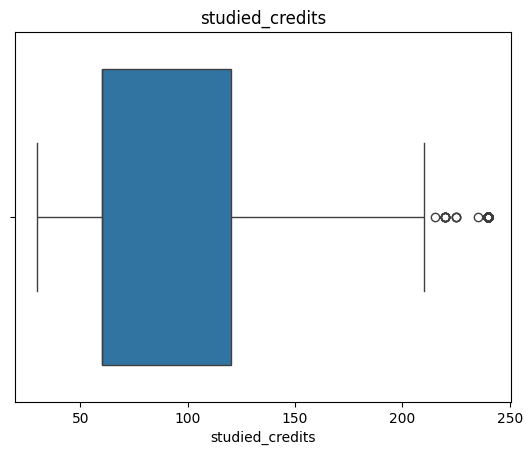

/Users/milton/anaconda3/envs/Statistics/lib/python3.12/site-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


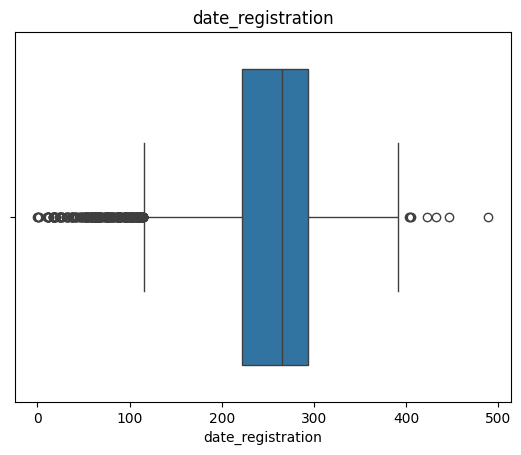

/Users/milton/anaconda3/envs/Statistics/lib/python3.12/site-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


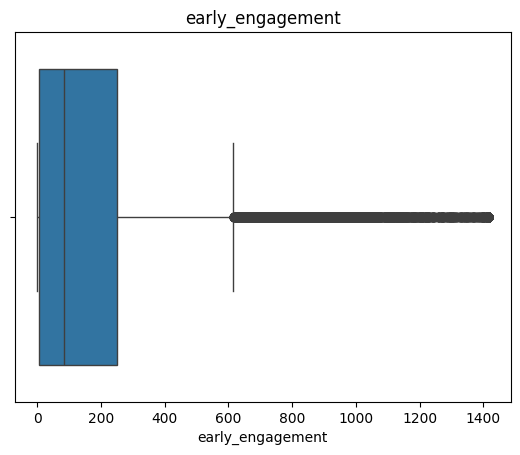

In [29]:
# For each numerical column
for col in ['studied_credits', 'date_registration', 'early_engagement']:
    # Create a boxplot
    sns.boxplot(x=df[col])
    
    # Show the plot with the column name as the title
    plt.title(col)
    plt.show()

## Univariate Analysis

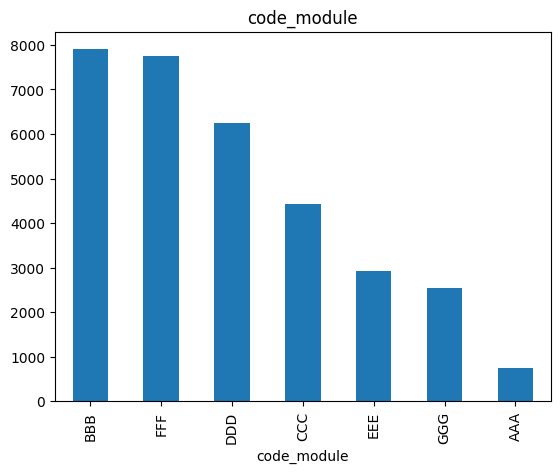

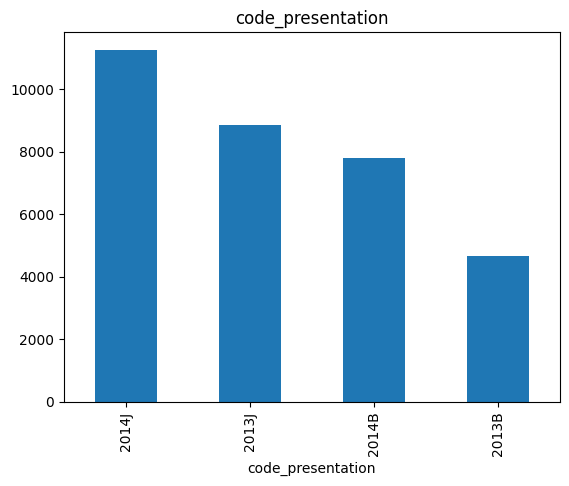

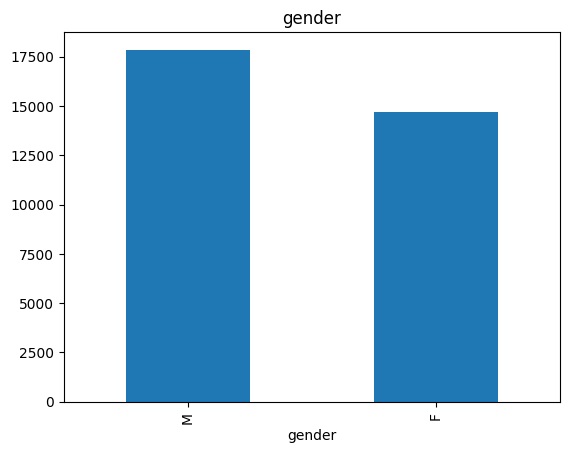

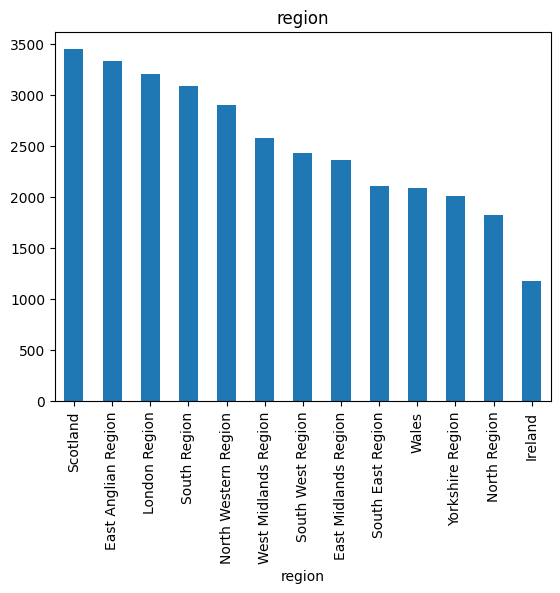

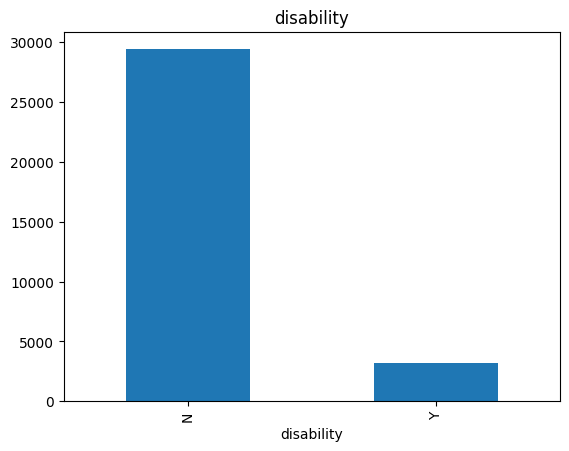

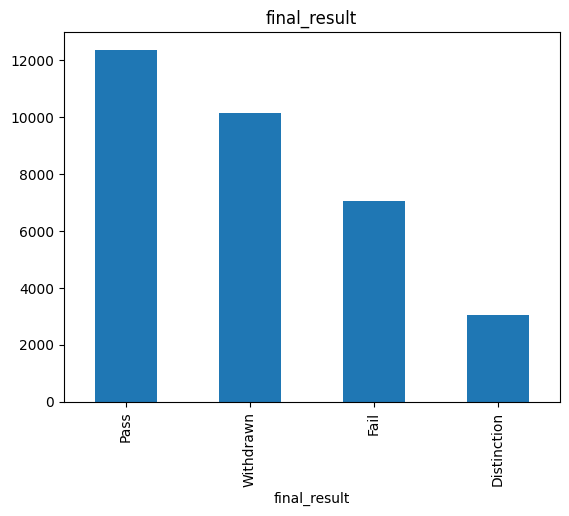

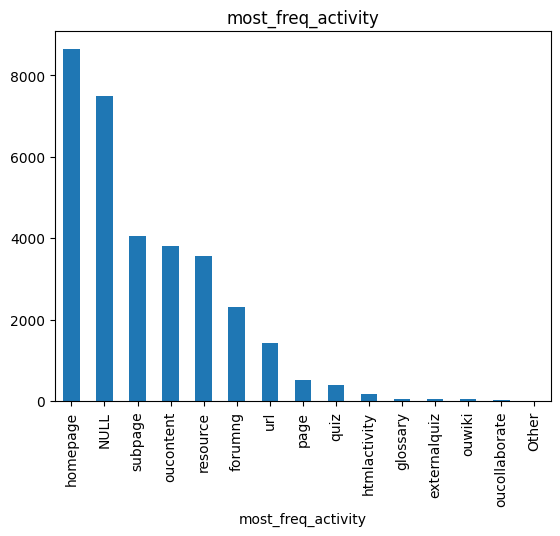

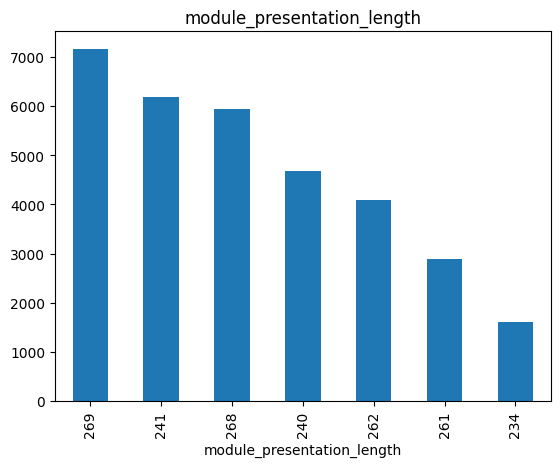

In [30]:
# Loop over nominal columns
for col in nominal_cols:
    df[col].value_counts().plot(kind='bar')
    plt.title(col)
    plt.show()

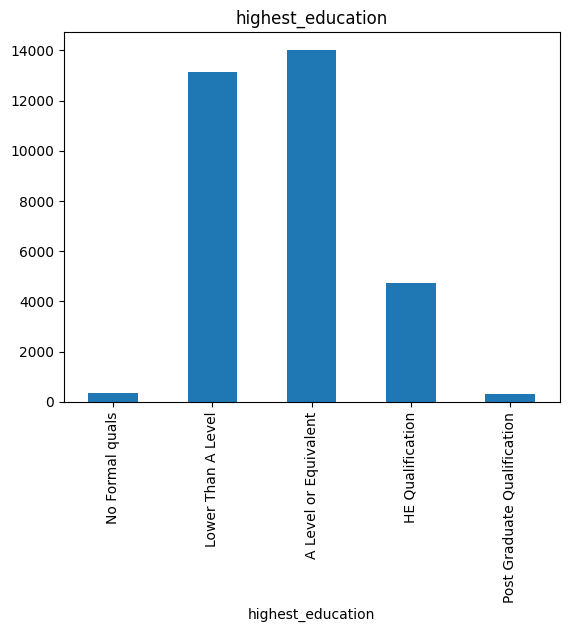

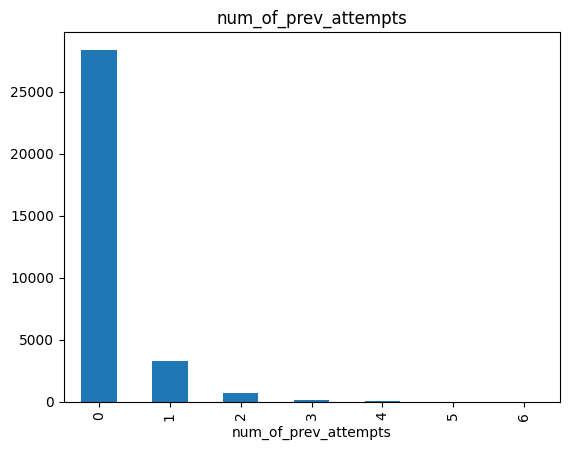

In [31]:
# Loop over ordinal columns
for col in ordinal_cols:
    df[col].value_counts().sort_index().plot(kind='bar')
    plt.title(col)
    plt.show()

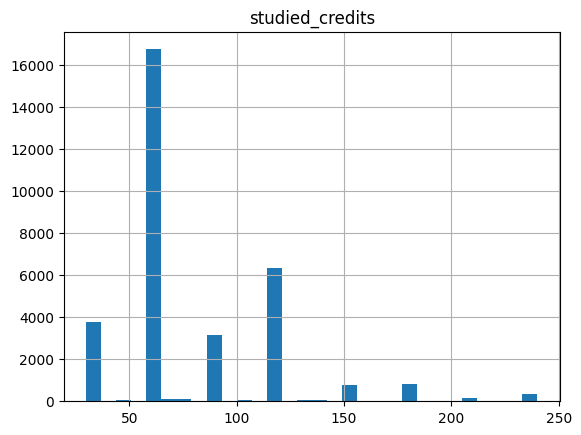

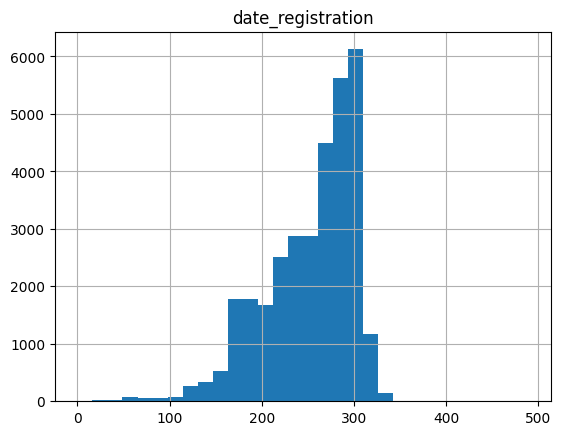

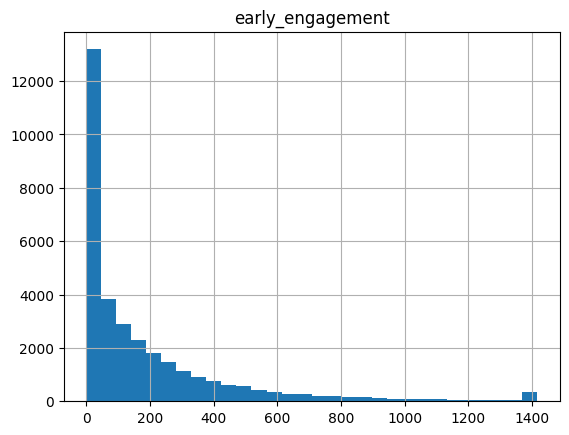

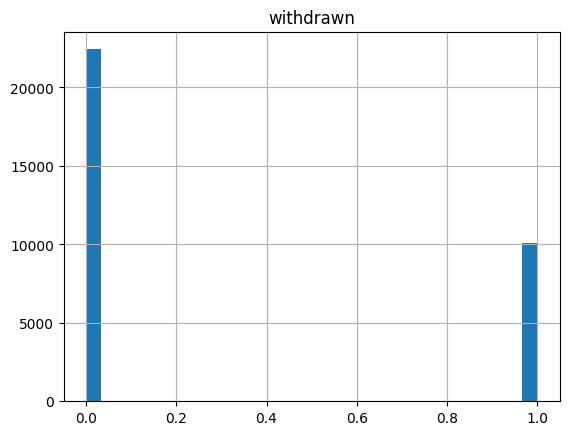

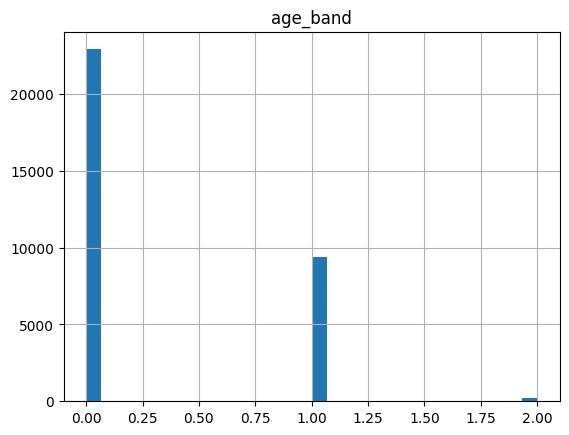

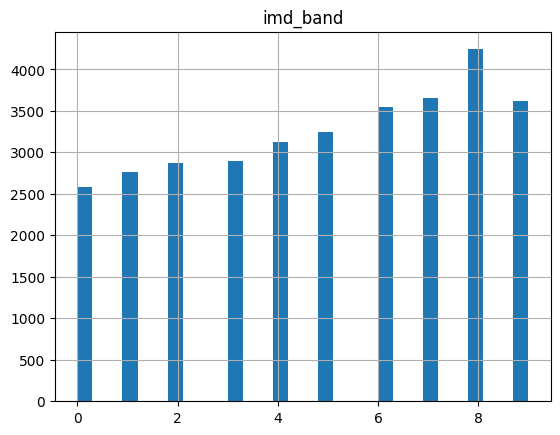

In [32]:
# Loop over numerical columns
for col in numerical_cols:
    df[col].hist(bins=30)
    plt.title(col)
    plt.show()

## Bivariate Analysis

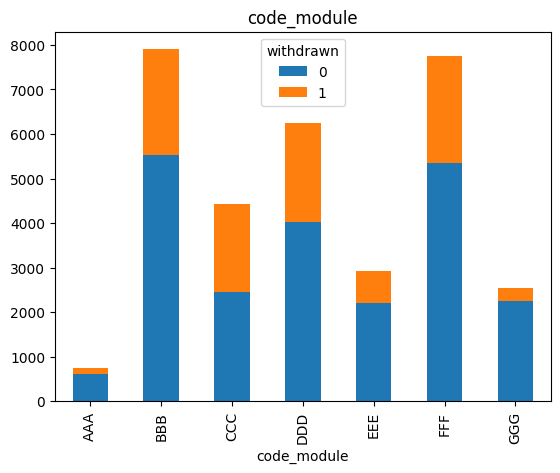

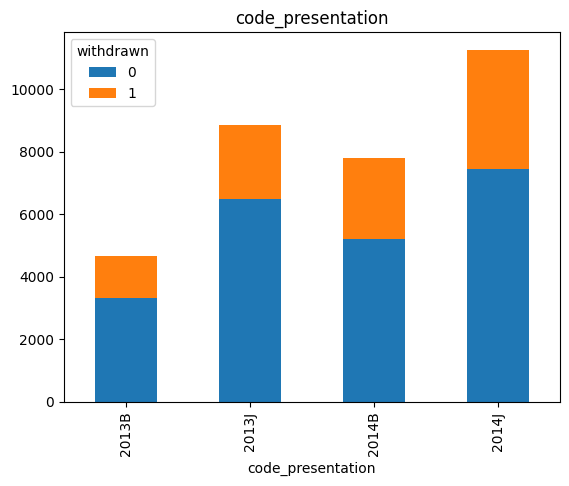

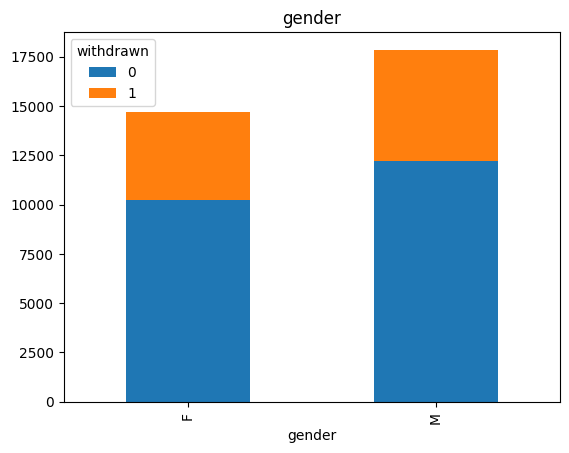

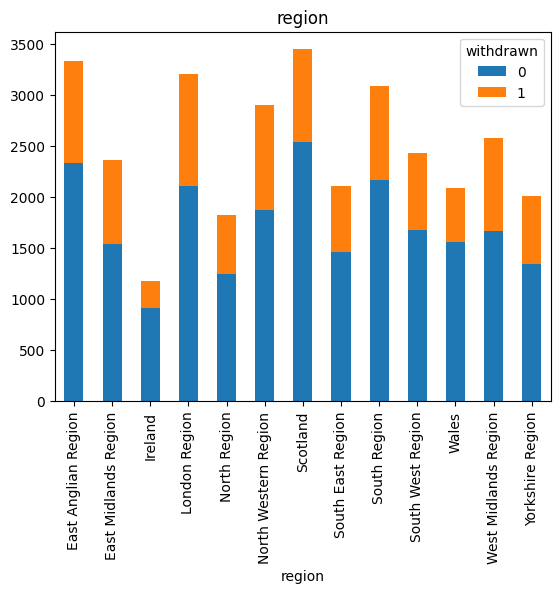

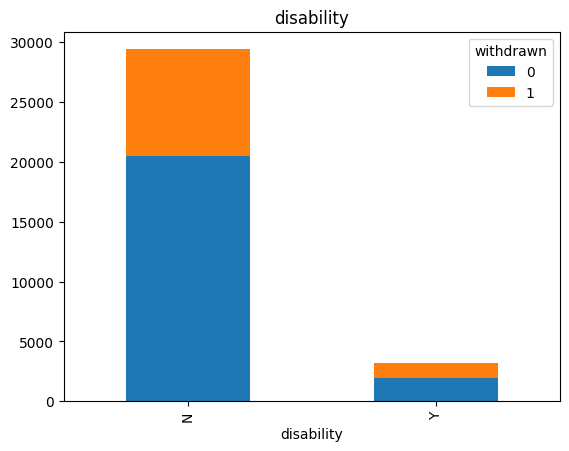

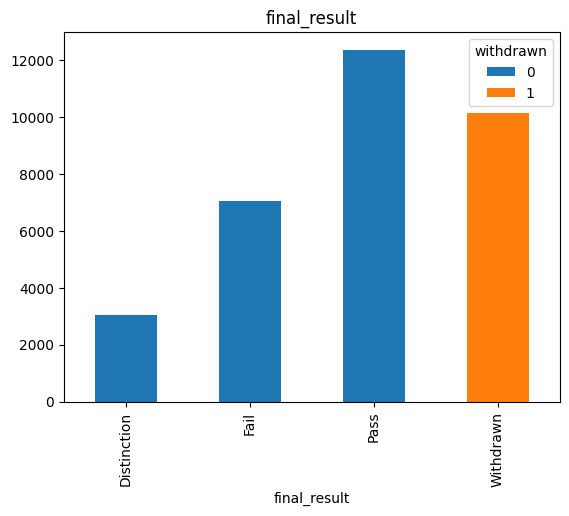

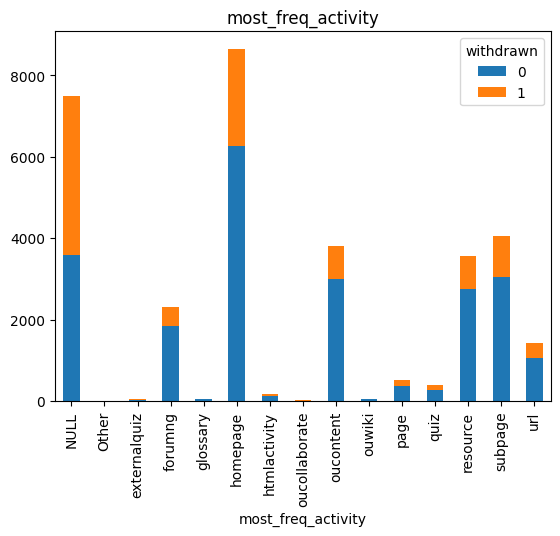

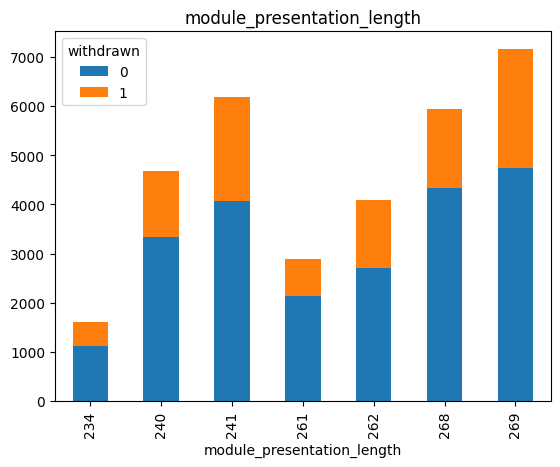

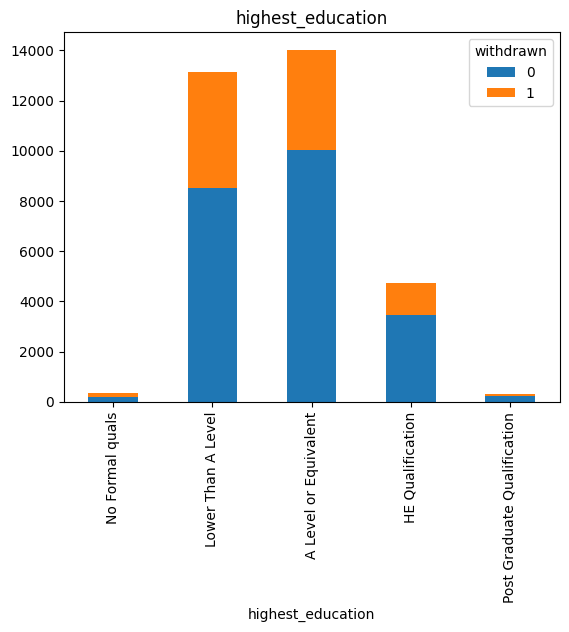

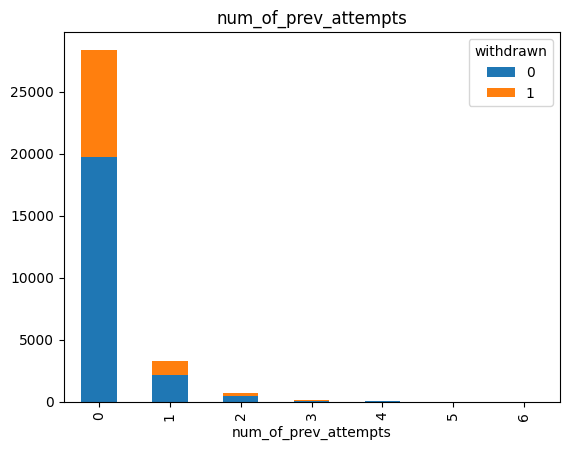

In [33]:
# Loop over nominal and ordinal columns
for col in nominal_cols + ordinal_cols:
    pd.crosstab(df[col], df['withdrawn']).plot(kind='bar', stacked=True)
    plt.title(col)
    plt.show()

## Correlation matrix

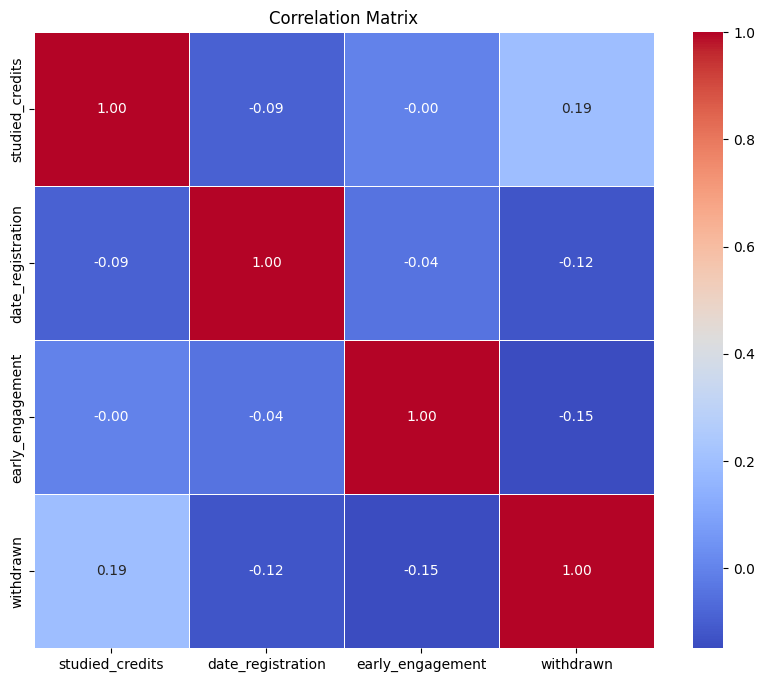

In [34]:
# Define categorical, ordinal, and numerical columns
nominal_cols = ['code_module', 'code_presentation', 'gender', 'region', 'disability', 'most_freq_activity', 'module_presentation_length']
ordinal_cols = ['highest_education', 'imd_band', 'age_band', 'num_of_prev_attempts']
numerical_cols = ['studied_credits', 'date_registration', 'early_engagement', 'withdrawn']  # Include target variable

# Select numerical columns from the DataFrame
numerical_df = df[numerical_cols]

# Compute correlation matrix
correlation_matrix = numerical_df.corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()


# Statistical Testing

In [35]:
df.columns

Index(['code_module', 'code_presentation', 'gender', 'region',
       'highest_education', 'imd_band', 'age_band', 'num_of_prev_attempts',
       'studied_credits', 'disability', 'final_result', 'date_registration',
       'early_engagement', 'most_freq_activity', 'module_presentation_length',
       'withdrawn'],
      dtype='object')

#### H0 = There is no significant difference between categorical variables and withdrawn

In [36]:
# Select categorical variables
categorical_vars = ['highest_education', 'gender', 'region', 'imd_band', 'age_band', 'disability']

# Perform chi-square test for each categorical variable
for cat_var in categorical_vars:
    # Create a contingency table
    contingency_table = pd.crosstab(df[cat_var], df['withdrawn'])
    
    # Check assumptions
    # Ensure expected cell counts are at least 5 for most cells
    if (contingency_table.values >= 5).all():
        # Perform chi-square test
        chi2_stat, p_val, _, _ = chi2_contingency(contingency_table)
        
        # Print results
        print(f"Chi-square test for {cat_var}:")
        print(f"Chi-square statistic: {chi2_stat}")
        print(f"P-value: {p_val}")
        if p_val < 0.05:
            print("Result: Statistically significant relationship (Reject null hypothesis)")
        else:
            print("Result: No statistically significant relationship (Fail to reject null hypothesis)")
        print("----------------------------------------")
    else:
        print(f"Chi-square test for {cat_var} cannot be performed due to low expected cell counts.")


Chi-square test for highest_education:
Chi-square statistic: 201.68805207086749
P-value: 1.6290391406358368e-42
Result: Statistically significant relationship (Reject null hypothesis)
----------------------------------------
Chi-square test for gender:
Chi-square statistic: 5.49825097754981
P-value: 0.019035503669634257
Result: Statistically significant relationship (Reject null hypothesis)
----------------------------------------
Chi-square test for region:
Chi-square statistic: 190.81577386639833
P-value: 2.5511715900002956e-34
Result: Statistically significant relationship (Reject null hypothesis)
----------------------------------------
Chi-square test for imd_band:
Chi-square statistic: 162.70846418587948
P-value: 2.031635902866033e-30
Result: Statistically significant relationship (Reject null hypothesis)
----------------------------------------
Chi-square test for age_band:
Chi-square statistic: 38.533005746273254
P-value: 4.292043516986003e-09
Result: Statistically significant 

In [37]:
numerical_variables = ['studied_credits', 'date_registration', 'early_engagement']

In [38]:
# Define a function to perform Shapiro-Wilk test for normality
def shapiro_test(data):
    """
    Perform Shapiro-Wilk test for normality.
    
    Parameters:
    - data: array-like, numerical data for the variable
    
    Returns:
    - stat: float, test statistic
    - p_value: float, p-value of the test
    """
    stat, p_value = shapiro(data)
    return stat, p_value

# Perform Shapiro-Wilk test for each numerical variable within each group
for variable in numerical_variables:
    print("Variable:", variable)
    for group_name, group_data in df.groupby('withdrawn')[variable]:
        stat, p_value = shapiro_test(group_data)
        print("Group:", group_name)
        print("Shapiro-Wilk Test Statistic:", stat)
        print("P-value:", p_value)
        if p_value > 0.05:
            print("Result: Normal distribution (Fail to reject null hypothesis)")
        else:
            print("Result: Non-normal distribution (Reject null hypothesis)")
        print("----------------------------------------")


Variable: studied_credits
Group: 0
Shapiro-Wilk Test Statistic: 0.7982133386420502
P-value: 9.348579263996264e-96
Result: Non-normal distribution (Reject null hypothesis)
----------------------------------------
Group: 1
Shapiro-Wilk Test Statistic: 0.8331402063177571
P-value: 5.791362885459826e-73
Result: Non-normal distribution (Reject null hypothesis)
----------------------------------------
Variable: date_registration
Group: 0
Shapiro-Wilk Test Statistic: 0.9160588964342089
P-value: 2.179452064556482e-75
Result: Non-normal distribution (Reject null hypothesis)
----------------------------------------
Group: 1
Shapiro-Wilk Test Statistic: 0.9300278019987543
P-value: 7.38180773309839e-56
Result: Non-normal distribution (Reject null hypothesis)
----------------------------------------
Variable: early_engagement
Group: 0
Shapiro-Wilk Test Statistic: 0.7378507673854771
P-value: 2.5839975817728786e-102
Result: Non-normal distribution (Reject null hypothesis)
-----------------------------

/var/folders/90/z83cxjcn6h3c4q15nk2qr1_00000gn/T/ipykernel_85356/3496978530.py:13: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 22431.
  stat, p_value = shapiro(data)
/var/folders/90/z83cxjcn6h3c4q15nk2qr1_00000gn/T/ipykernel_85356/3496978530.py:13: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 10117.
  stat, p_value = shapiro(data)


#### Assumption of normality is not met so proceeding with Mann-Whitney U test 

#### H0 = There is no significant difference between numerical variables and withdrawn

In [39]:
# Perform Mann-Whitney U test for each numerical variable
for variable in numerical_variables:
    # Perform Mann-Whitney U test
    statistic, p_value = mannwhitneyu(df[df['withdrawn'] == 1][variable], df[df['withdrawn'] == 0][variable])
    
    # Display test results
    print(f"Mann-Whitney U Test for {variable}:")
    print("Mann-Whitney U statistic:", statistic)
    print("P-value:", p_value)
    
    # Interpret the results
    if p_value < 0.05:
        print("Result: Statistically significant difference (Reject null hypothesis)")
    else:
        print("Result: No statistically significant difference (Fail to reject null hypothesis)")


Mann-Whitney U Test for studied_credits:
Mann-Whitney U statistic: 138036265.0
P-value: 1.2234295553292706e-251
Result: Statistically significant difference (Reject null hypothesis)
Mann-Whitney U Test for date_registration:
Mann-Whitney U statistic: 97193914.5
P-value: 1.4028568892972728e-95
Result: Statistically significant difference (Reject null hypothesis)
Mann-Whitney U Test for early_engagement:
Mann-Whitney U statistic: 80524775.0
P-value: 0.0
Result: Statistically significant difference (Reject null hypothesis)


# Models

### Neural Network

In [40]:
# Define categorical variables
nominal_cols = ['code_module', 'code_presentation', 'gender', 'region', 'disability', 'most_freq_activity', 'module_presentation_length']
ordinal_cols = ['highest_education', 'imd_band', 'age_band', 'num_of_prev_attempts']
numerical_cols = ['studied_credits', 'date_registration', 'early_engagement']

# Define the decision threshold
threshold = 0.6  # adjust this to find the best balance between precision and recall

# Define preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),  
        ('ord', OrdinalEncoder(), ordinal_cols),
        ('nom', OneHotEncoder(), nominal_cols)
    ])

# Define pipeline with feature engineering and the best parameters
model = imPipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', MLPClassifier(hidden_layer_sizes=(50,), activation='logistic', solver='lbfgs', alpha=0.1, learning_rate='constant', learning_rate_init=0.001, max_iter=5000, random_state=42))
])

# Define target variable and features
y = df['withdrawn']
X = df.drop('withdrawn', axis=1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the model
model.fit(X_train, y_train)

# Predict the probabilities of the positive class for the training set
y_train_pred_prob = model.predict_proba(X_train)[:, 1]

# Classify the instances based on the decision threshold
y_train_pred = (y_train_pred_prob > threshold).astype(int)

# Evaluate the model on the training set
print("Training Set Performance:")
print(classification_report(y_train, y_train_pred))

# Predict the probabilities of the positive class
y_pred_prob = model.predict_proba(X_test)[:, 1]

# Classify the instances based on the decision threshold
y_pred = (y_pred_prob > threshold).astype(int)

# Evaluate the model on the test set
print("Test Set Performance:")
print(classification_report(y_test, y_pred))

print("F1 Score:")  
print(f1_score(y_test, y_pred, average='macro'))  # Calculate F1 score on test set

Training Set Performance:
              precision    recall  f1-score   support

           0       0.80      0.95      0.87     17934
           1       0.81      0.49      0.61      8104

    accuracy                           0.81     26038
   macro avg       0.81      0.72      0.74     26038
weighted avg       0.81      0.81      0.79     26038

Test Set Performance:
              precision    recall  f1-score   support

           0       0.75      0.86      0.80      4497
           1       0.55      0.37      0.44      2013

    accuracy                           0.71      6510
   macro avg       0.65      0.62      0.62      6510
weighted avg       0.69      0.71      0.69      6510

F1 Score:
0.624448101449389


AUC-ROC:  0.692319911679266


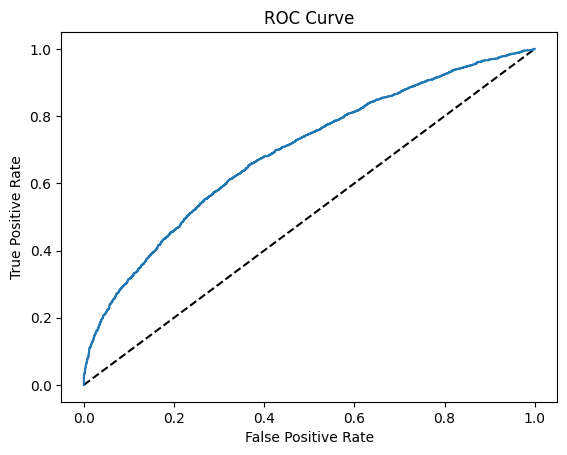

In [41]:
# Compute predicted probabilities
y_pred_prob = model.predict_proba(X_test)[:, 1]

# Compute and print AUC score
print("AUC-ROC: ", roc_auc_score(y_test, y_pred_prob))

# Compute and plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [42]:
# Define the parameter grid
param_grid = {
    'classifier__hidden_layer_sizes': [(50,), (100,), (200,)],
    'classifier__alpha': [0.0001, 0.001, 0.01],
}

# Perform grid search
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='f1')
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Fit the model with the best parameters
best_model = grid_search.best_estimator_
best_model.fit(X_train, y_train)

# Predict the probabilities of the positive class for the training set
y_train_pred_prob = best_model.predict_proba(X_train)[:, 1]

# Classify the instances based on the decision threshold
y_train_pred = (y_train_pred_prob > threshold).astype(int)

# Evaluate the model on the training set
print("Training Set Performance:")
print(classification_report(y_train, y_train_pred))

# Predict the probabilities of the positive class
y_pred_prob = best_model.predict_proba(X_test)[:, 1]

# Classify the instances based on the decision threshold
y_pred = (y_pred_prob > threshold).astype(int)

# Evaluate the model on the test set
print("Test Set Performance:")
print(classification_report(y_test, y_pred))

print("F1 Score:")  
print(f1_score(y_test, y_pred, average='macro'))  # Calculate F1 score on test set


KeyboardInterrupt: 

### Logistic Regression

#### Logistic Regression (baseline)

In [43]:
# Define categorical variables
nominal_cols = ['code_module', 'code_presentation', 'gender', 'region', 'disability', 'most_freq_activity', 'module_presentation_length']
ordinal_cols = ['highest_education', 'imd_band', 'age_band', 'num_of_prev_attempts']
numerical_cols = ['studied_credits', 'date_registration', 'early_engagement']

# Define the decision threshold
threshold = 0.6  # adjust this to find the best balance between precision and recall

# Define preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),  
        ('ord', OrdinalEncoder(), ordinal_cols),
        ('nom', OneHotEncoder(handle_unknown='ignore'), nominal_cols)
    ])

# Define pipeline with feature engineering and logistic regression

model = imPipeline(steps=[
    ('preprocessor', preprocessor),
                              ('model', LogisticRegression(class_weight='balanced', max_iter=5000, random_state=42, C=0.1, fit_intercept=True, penalty='l2', solver='liblinear'))])

# Define target variable and features
y = df['withdrawn']
X = df.drop('withdrawn', axis=1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the model
model.fit(X_train, y_train)

# Predict the probabilities of the positive class for the training set
y_train_pred_prob = model.predict_proba(X_train)[:, 1]

# Classify the instances based on the decision threshold
y_train_pred = (y_train_pred_prob > threshold).astype(int)

# Evaluate the model on the training set
print("Training Set Performance:")
print(classification_report(y_train, y_train_pred))

# Predict the probabilities of the positive class
y_pred_prob = model.predict_proba(X_test)[:, 1]

# Classify the instances based on the decision threshold
y_pred = (y_pred_prob > threshold).astype(int)

# Evaluate the model on the test set
print("Test Set Performance:")
print(classification_report(y_test, y_pred))

print("Accuracy Score:")
print(accuracy_score(y_test, y_pred))

print("F1 Score:")  # Changed print statement to reflect F1 score
print(f1_score(y_test, y_pred, average='macro'))  # Calculate F1 score on test set

Training Set Performance:
              precision    recall  f1-score   support

           0       0.78      0.83      0.81     17934
           1       0.56      0.47      0.51      8104

    accuracy                           0.72     26038
   macro avg       0.67      0.65      0.66     26038
weighted avg       0.71      0.72      0.71     26038

Test Set Performance:
              precision    recall  f1-score   support

           0       0.79      0.84      0.81      4497
           1       0.58      0.49      0.53      2013

    accuracy                           0.73      6510
   macro avg       0.68      0.66      0.67      6510
weighted avg       0.72      0.73      0.72      6510

Accuracy Score:
0.730568356374808
F1 Score:
0.6703709545707324


In [ ]:
# Define the number of folds for cross-validation
cv = StratifiedKFold(n_splits=5)

# Perform cross-validation on the pipeline
scores = cross_val_score(model, X, y, cv=cv, scoring='f1_macro')

# Print the cross-validation scores
print("Cross-validation F1 scores:", scores)

# Print the mean and standard deviation of the cross-validation scores
print("Mean cross-validation F1 score:", scores.mean())
print("Standard deviation of cross-validation F1 score:", scores.std())

Cross-validation F1 scores: [0.6353962  0.45628069 0.4746179  0.47244516 0.6107075 ]
Mean cross-validation F1 score: 0.5298894910276924
Standard deviation of cross-validation F1 score: 0.07672844462276691


AUC:  0.7377952802005996


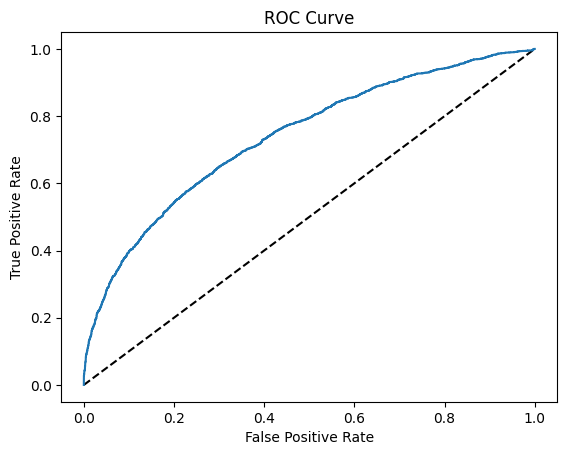

In [44]:
# Compute predicted probabilities
y_pred_prob = model.predict_proba(X_test)[:, 1]

# Compute and print AUC score
print("AUC: ", roc_auc_score(y_test, y_pred_prob))

# Compute and plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

#### Logistic Regression Resampling 

In [45]:
# Define the decision threshold
threshold = 0.6  # adjust this to find the best balance between precision and recall

# Define preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),  
        ('ord', OrdinalEncoder(), ordinal_cols),
        ('nom', OneHotEncoder(handle_unknown='ignore'), nominal_cols)
    ])

# Define pipeline with feature engineering and logistic regression
model = imPipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=5000, random_state=42))
])


# Define target variable and features
y = df['withdrawn']
X = df.drop('withdrawn', axis=1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the resampling method
ros = RandomOverSampler(random_state=42)

# Apply the resampling on the training data only
X_train_res, y_train_res = ros.fit_resample(X_train, y_train)

# Fit the model on the resampled training set
model.fit(X_train_res, y_train_res)

# Predict the probabilities of the positive class for the resampled training set
y_train_pred_prob_res = model.predict_proba(X_train_res)[:, 1]

# Classify the instances based on the decision threshold
y_train_pred_res = (y_train_pred_prob_res > threshold).astype(int)

# Evaluate the model on the resampled training set
print("Resampled Training Set Performance:")
print(classification_report(y_train_res, y_train_pred_res))

# Predict the probabilities of the positive class for the test set
y_pred_prob = model.predict_proba(X_test)[:, 1]

# Classify the instances based on the decision threshold
y_pred = (y_pred_prob > threshold).astype(int)

# Evaluate the model on the test set
print("Test Set Performance:")
print(classification_report(y_test, y_pred))

print("Accuracy Score:")
print(accuracy_score(y_test, y_pred))

print("----------------------------------------")

print("F1 Score:")  # Changed print statement to reflect F1 score
print(f1_score(y_test, y_pred, average='macro'))  # Calculate F1 score on test set

# Define the number of folds for cross-validation
cv = StratifiedKFold(n_splits=5)

# Perform cross-validation on the model
scores = cross_val_score(model, X, y, cv=cv, scoring='f1_macro')

print("----------------------------------------")

# Print the cross-validation scores
print("Cross-validation F1 scores:", scores)

# Print the mean and standard deviation of the cross-validation scores
print("Mean cross-validation F1 score:", scores.mean())
print("Standard deviation of cross-validation F1 score:", scores.std())

Resampled Training Set Performance:
              precision    recall  f1-score   support

           0       0.61      0.83      0.71     17934
           1       0.74      0.48      0.58     17934

    accuracy                           0.66     35868
   macro avg       0.68      0.66      0.64     35868
weighted avg       0.68      0.66      0.64     35868

Test Set Performance:
              precision    recall  f1-score   support

           0       0.79      0.83      0.81      4497
           1       0.57      0.49      0.53      2013

    accuracy                           0.73      6510
   macro avg       0.68      0.66      0.67      6510
weighted avg       0.72      0.73      0.72      6510

Accuracy Score:
0.7284178187403993
----------------------------------------
F1 Score:
0.6688000640894011
----------------------------------------
Cross-validation F1 scores: [0.53437312 0.55541282 0.48470562 0.51129549 0.52011499]
Mean cross-validation F1 score: 0.5211804087491674
Standa

AUC:  0.7373075675222462


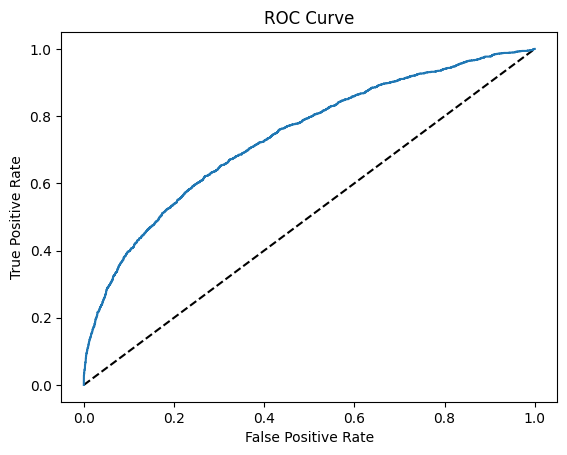

In [ ]:
# Compute predicted probabilities
y_pred_prob = model.predict_proba(X_test)[:, 1]

# Compute and print AUC score
print("AUC: ", roc_auc_score(y_test, y_pred_prob))

# Compute and plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

#### Logistic Regression SMOTE

In [ ]:
# Define categorical variables
nominal_cols = ['code_module', 'code_presentation', 'gender', 'region', 'disability', 'most_freq_activity', 'module_presentation_length']
ordinal_cols = ['highest_education', 'imd_band', 'age_band', 'num_of_prev_attempts']
numerical_cols = ['studied_credits', 'date_registration', 'early_engagement']

# Define the decision threshold
threshold = 0.605  # adjust this to find the best balance between precision and recall


# Define target variable and features
y = df['withdrawn']
X = df.drop('withdrawn', axis=1)

# Define pipeline with feature engineering
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),  
        ('ord', OrdinalEncoder(), ordinal_cols),
        ('nom', OneHotEncoder(handle_unknown='ignore'), nominal_cols)
    ])


# Define pipeline
model = imPipeline(steps=[('preprocessor', preprocessor),
                              ('smote', SMOTE(random_state=42)),
                              ('model', LogisticRegression(class_weight='balanced', max_iter=5000, random_state=42, C=0.1, fit_intercept=True, penalty='l2', solver='lbfgs'))])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the model
model.fit(X_train, y_train)

# Predict the probabilities of the positive class for the training set
y_train_pred_prob = model.predict_proba(X_train)[:, 1]

# Classify the instances based on the decision threshold
y_train_pred = (y_train_pred_prob > threshold).astype(int)

# Evaluate the model on the training set
print("Training Set Performance:")
print(classification_report(y_train, y_train_pred))

# Predict the probabilities of the positive class
y_pred_prob = model.predict_proba(X_test)[:, 1]

# Classify the instances based on the decision threshold
y_pred = (y_pred_prob > threshold).astype(int)

# Evaluate the model on the test set
print("Test Set Performance:")
print(classification_report(y_test, y_pred))

print("Accuracy Score:")
print(accuracy_score(y_test, y_pred))

print("----------------------------------------")

print("F1 Score:")  # Changed print statement to reflect F1 score
print(f1_score(y_test, y_pred, average='macro'))  # Calculate F1 score on test set

# Define the number of folds for cross-validation
cv = StratifiedKFold(n_splits=5)

# Perform cross-validation on the model
scores = cross_val_score(model, X, y, cv=cv, scoring='f1_macro')

print("----------------------------------------")

# Print the cross-validation scores
print("Cross-validation F1 scores:", scores)

print("----------------------------------------")

# Print the mean and standard deviation of the cross-validation scores
print("Mean cross-validation F1 score:", scores.mean())
print("Standard deviation of cross-validation F1 score:", scores.std())

Training Set Performance:
              precision    recall  f1-score   support

           0       0.78      0.84      0.81     17934
           1       0.56      0.47      0.51      8104

    accuracy                           0.72     26038
   macro avg       0.67      0.65      0.66     26038
weighted avg       0.71      0.72      0.71     26038

Test Set Performance:
              precision    recall  f1-score   support

           0       0.79      0.84      0.81      4497
           1       0.58      0.49      0.53      2013

    accuracy                           0.73      6510
   macro avg       0.68      0.67      0.67      6510
weighted avg       0.72      0.73      0.73      6510

Accuracy Score:
0.7321044546850999
----------------------------------------
F1 Score:
0.6717220229120069
----------------------------------------
Cross-validation F1 scores: [0.64297706 0.46766399 0.47885454 0.47977257 0.61337053]
----------------------------------------
Mean cross-validation F1 s

In [ ]:
# Fit the model
model.fit(X_train, y_train)

# Get the logistic regression step from the pipeline
logreg = model.named_steps['model'] 

# Get the preprocessor step from the pipeline
preprocessor = model.named_steps['preprocessor']

# Get the feature names after preprocessing
feature_names = (preprocessor.transformers_[0][2] + 
                 preprocessor.transformers_[1][2] + 
                 list(preprocessor.named_transformers_['nom'].get_feature_names_out(nominal_cols)))

# Get the coefficients from the logistic regression model
coefficients = logreg.coef_[0]

# Create a DataFrame of feature names and coefficients
feature_importances = pd.DataFrame({'feature': feature_names, 'coefficient': coefficients})

# Sort the DataFrame by the absolute value of the coefficients
feature_importances = feature_importances.reindex(feature_importances.coefficient.abs().sort_values(ascending=False).index)

# Print the feature importances
print(feature_importances)

                             feature  coefficient
13                   code_module_GGG    -1.076493
9                    code_module_CCC     0.975591
35           most_freq_activity_NULL     0.961044
10                   code_module_DDD     0.481408
11                   code_module_EEE    -0.405342
7                    code_module_AAA    -0.377865
22                    region_Ireland    -0.355448
6               num_of_prev_attempts    -0.354505
41   most_freq_activity_htmlactivity     0.343594
2                   early_engagement    -0.323691
46           most_freq_activity_quiz    -0.313920
43      most_freq_activity_oucontent    -0.302314
0                    studied_credits     0.298436
30                      region_Wales    -0.292433
38        most_freq_activity_forumng    -0.287306
33                      disability_N    -0.244914
49            most_freq_activity_url    -0.237069
47       most_freq_activity_resource    -0.227673
19                          gender_M    -0.205569


AUC:  0.736699556065472


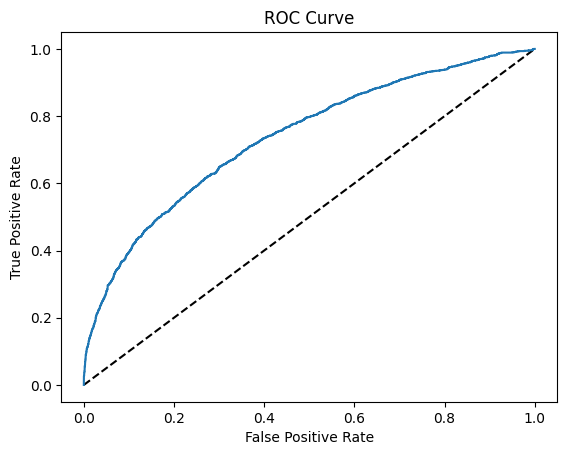

In [ ]:
# Compute predicted probabilities
y_pred_prob = model.predict_proba(X_test)[:, 1]

# Compute and print AUC score
print("AUC: ", roc_auc_score(y_test, y_pred_prob))

# Compute and plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

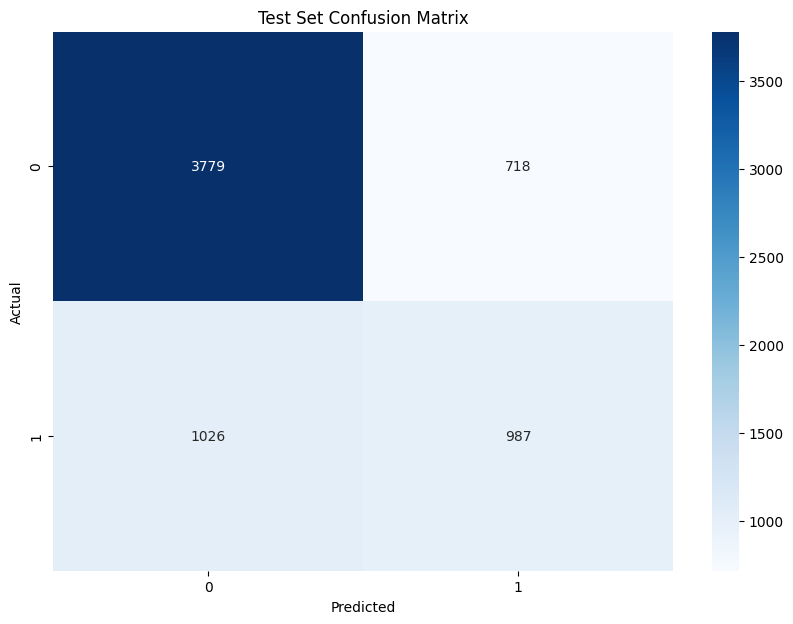

In [ ]:
# Generate confusion matrix for the test set
test_conf_matrix = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(test_conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Test Set Confusion Matrix")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
# Define pipeline
pipeline = imPipeline(steps=[('preprocessor', preprocessor),
                              ('smote', SMOTE(random_state=42)),
                              ('model', LogisticRegression(class_weight='balanced', max_iter=5000, random_state=42))])

# Define the parameter grid
param_grid = {
    'model__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'model__penalty': ['l1', 'l2'],
    'model__solver': ['liblinear', 'saga', 'lbfgs'],
    'model__fit_intercept': [True, False],
    'model__class_weight': [None, 'balanced'],
    'model__max_iter': [1000, 2000, 5000, 10000] 
}

# Create a StratifiedKFold object
stratified_kfold = StratifiedKFold(n_splits=10)

# Create a GridSearchCV object
grid_search = GridSearchCV(pipeline, param_grid, cv=stratified_kfold, scoring='f1_macro')

# Create a GridSearchCV object
grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='f1_macro')  # Changed scoring to 'f1_macro'

# Fit the GridSearchCV object to the data
grid_search.fit(X_train, y_train)

# Print the best parameters
print("Best parameters: ", grid_search.best_params_)

# Print the best score
print("Best F1 score: ", grid_search.best_score_)  # Changed print statement to reflect F1 score

# Use the best estimator to make predictions
best_estimator = grid_search.best_estimator_

y_pred = best_estimator.predict(X_test)

# Evaluate the model on the test set
print("Test Set Performance:")
print(classification_report(y_test, y_pred))

print("F1 Score:")  # Changed print statement to reflect F1 score
print(f1_score(y_test, y_pred, average='macro'))  # Calculate F1 score on test set

KeyboardInterrupt: 

#### Logistic Regression with Undersampling

In [ ]:
# Define categorical variables
nominal_cols = ['code_module', 'code_presentation', 'gender', 'region', 'disability', 'most_freq_activity', 'module_presentation_length']
ordinal_cols = ['highest_education', 'imd_band', 'age_band', 'num_of_prev_attempts']
numerical_cols = ['studied_credits', 'date_registration', 'early_engagement']

# Define the decision threshold
threshold = 0.6  # adjust this to find the best balance between precision and recall

# Define preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),  
        ('ord', OrdinalEncoder(), ordinal_cols),
        ('nom', OneHotEncoder(handle_unknown='ignore'), nominal_cols)
    ])

# Define undersampler
undersampler = RandomUnderSampler(random_state=42)

# Define pipeline with feature engineering, undersampling, and logistic regression
model = imPipeline(steps=[
    ('preprocessor', preprocessor),
    ('undersampler', undersampler),
    ('model', LogisticRegression(class_weight='balanced', max_iter=5000, random_state=42, C=0.1, fit_intercept=True, penalty='l2', solver='liblinear'))])

# Define target variable and features
y = df['withdrawn']
X = df.drop('withdrawn', axis=1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the model
model.fit(X_train, y_train)

# Predict the probabilities of the positive class for the training set
y_train_pred_prob = model.predict_proba(X_train)[:, 1]

# Classify the instances based on the decision threshold
y_train_pred = (y_train_pred_prob > threshold).astype(int)

# Evaluate the model on the training set
print("Training Set Performance:")
print(classification_report(y_train, y_train_pred))

# Predict the probabilities of the positive class
y_pred_prob = model.predict_proba(X_test)[:, 1]

# Classify the instances based on the decision threshold
y_pred = (y_pred_prob > threshold).astype(int)

# Evaluate the model on the test set
print("Test Set Performance:")
print(classification_report(y_test, y_pred))

print("Accuracy Score:")
print(accuracy_score(y_test, y_pred))

print("----------------------------------------")

print("F1 Score:")  # Changed print statement to reflect F1 score
print(f1_score(y_test, y_pred, average='macro'))  # Calculate F1 score on test set

# Define the number of folds for cross-validation
cv = StratifiedKFold(n_splits=5)

# Perform cross-validation on the model
scores = cross_val_score(model, X, y, cv=cv, scoring='f1_macro')

print("----------------------------------------")

# Print the cross-validation scores
print("Cross-validation F1 scores:", scores)

print("----------------------------------------")

# Print the mean and standard deviation of the cross-validation scores
print("Mean cross-validation F1 score:", scores.mean())
print("Standard deviation of cross-validation F1 score:", scores.std())

Training Set Performance:
              precision    recall  f1-score   support

           0       0.78      0.84      0.81     17934
           1       0.56      0.47      0.51      8104

    accuracy                           0.72     26038
   macro avg       0.67      0.65      0.66     26038
weighted avg       0.71      0.72      0.71     26038

Test Set Performance:
              precision    recall  f1-score   support

           0       0.78      0.84      0.81      4497
           1       0.57      0.48      0.52      2013

    accuracy                           0.73      6510
   macro avg       0.68      0.66      0.67      6510
weighted avg       0.72      0.73      0.72      6510

Accuracy Score:
0.7287250384024577
----------------------------------------
F1 Score:
0.6674734850202744
----------------------------------------
Cross-validation F1 scores: [0.63699213 0.46199984 0.478278   0.48039745 0.61197026]
----------------------------------------
Mean cross-validation F1 s

AUC:  0.7372502350465803


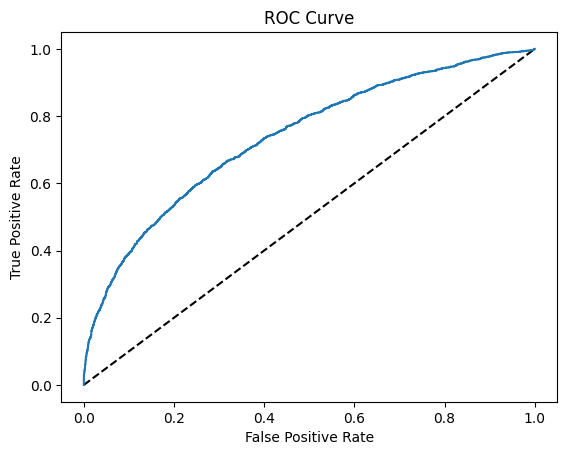

In [ ]:
# Compute predicted probabilities
y_pred_prob = model.predict_proba(X_test)[:, 1]

# Compute and print AUC score
print("AUC: ", roc_auc_score(y_test, y_pred_prob))

# Compute and plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

#### Logistic Regression Over and Under sampling combination

In [ ]:
# Define categorical variables
nominal_cols = ['code_module', 'code_presentation', 'gender', 'region', 'disability', 'most_freq_activity', 'module_presentation_length']
ordinal_cols = ['highest_education', 'imd_band', 'age_band', 'num_of_prev_attempts']
numerical_cols = ['studied_credits', 'date_registration', 'early_engagement']

# Define the decision threshold
threshold = 0.605 # adjust this to find the best balance between precision and recall

# Define preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),  
        ('ord', OrdinalEncoder(), ordinal_cols),
        ('nom', OneHotEncoder(handle_unknown='ignore'), nominal_cols)
    ])

# Define oversampler and undersampler
oversampler = SMOTE(random_state=42)
undersampler = RandomUnderSampler(random_state=42)

# Define pipeline with feature engineering, oversampling, undersampling, and logistic regression
model = imPipeline(steps=[
    ('preprocessor', preprocessor),
    ('oversampler', oversampler),
    ('undersampler', undersampler),
    ('model', LogisticRegression(max_iter=1000, class_weight={0: 1, 1: 1}, C=0.1, penalty='l2', solver='lbfgs'))])


# Define target variable and features
y = df['withdrawn']
X = df.drop('withdrawn', axis=1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Fit the model
model.fit(X_train, y_train)

# Predict the probabilities of the positive class for the training set
y_train_pred_prob = model.predict_proba(X_train)[:, 1]

# Classify the instances based on the decision threshold
y_train_pred = (y_train_pred_prob > threshold).astype(int)

# Evaluate the model on the training set
print("Training Set Performance:")
print(classification_report(y_train, y_train_pred))

# Predict the probabilities of the positive class
y_pred_prob = model.predict_proba(X_test)[:, 1]

# Classify the instances based on the decision threshold
y_pred = (y_pred_prob > threshold).astype(int)

# Evaluate the model on the test set
print("Test Set Performance:")
print(classification_report(y_test, y_pred))

print("Accuracy Score:")
print(accuracy_score(y_test, y_pred))

print("----------------------------------------")

print("F1 Score:")  # Changed print statement to reflect F1 score
print(f1_score(y_test, y_pred, average='macro'))  # Calculate F1 score on test set

# Define the number of folds for cross-validation
cv = StratifiedKFold(n_splits=5)

# Perform cross-validation on the model
scores = cross_val_score(model, X, y, cv=cv, scoring='f1_macro')

print("----------------------------------------")

# Print the cross-validation scores
print("Cross-validation F1 scores:", scores)

print("----------------------------------------")

# Print the mean and standard deviation of the cross-validation scores
print("Mean cross-validation F1 score:", scores.mean())
print("Standard deviation of cross-validation F1 score:", scores.std())
print(f1_score(y_test, y_pred, average='macro'))  # Calculate F1 score on test set



Training Set Performance:
              precision    recall  f1-score   support

           0       0.78      0.84      0.81     17934
           1       0.56      0.47      0.51      8104

    accuracy                           0.72     26038
   macro avg       0.67      0.65      0.66     26038
weighted avg       0.71      0.72      0.71     26038

Test Set Performance:
              precision    recall  f1-score   support

           0       0.79      0.84      0.81      4497
           1       0.58      0.49      0.53      2013

    accuracy                           0.73      6510
   macro avg       0.68      0.67      0.67      6510
weighted avg       0.72      0.73      0.73      6510

Accuracy Score:
0.7321044546850999
----------------------------------------
F1 Score:
0.6717220229120069
----------------------------------------
Cross-validation F1 scores: [0.64297706 0.46766399 0.47885454 0.47977257 0.61337053]
----------------------------------------
Mean cross-validation F1 s

In [ ]:
# Define the parameter grid
param_grid = {
    'model__class_weight': [{0: 1, 1: w} for w in [1, 5, 10, 20, 50, 100]],

}


# Define the grid search
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='f1', verbose=1, n_jobs=-1)

# Fit the grid search
grid_search.fit(X_train, y_train)

# Print the best parameters and the best score
print("Best parameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

# Use the best estimator to make predictions
best_model = grid_search.best_estimator_

# Predict the probabilities of the positive class
y_pred_prob = best_model.predict_proba(X_test)[:, 1]

# Classify the instances based on the decision threshold
y_pred = (y_pred_prob > threshold).astype(int)

# Evaluate the model on the test set
print("Test Set Performance:")
print(classification_report(y_test, y_pred))

print("Accuracy Score:")
print(accuracy_score(y_test, y_pred))

print("F1 Score:")  
print(f1_score(y_test, y_pred, average='macro'))  

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best parameters:  {'model__class_weight': {0: 1, 1: 1}}
Best score:  0.5478477053992862
Test Set Performance:
              precision    recall  f1-score   support

           0       0.79      0.83      0.81      4497
           1       0.57      0.50      0.53      2013

    accuracy                           0.73      6510
   macro avg       0.68      0.67      0.67      6510
weighted avg       0.72      0.73      0.72      6510

Accuracy Score:
0.7302611367127496
F1 Score:
0.6714652066193227


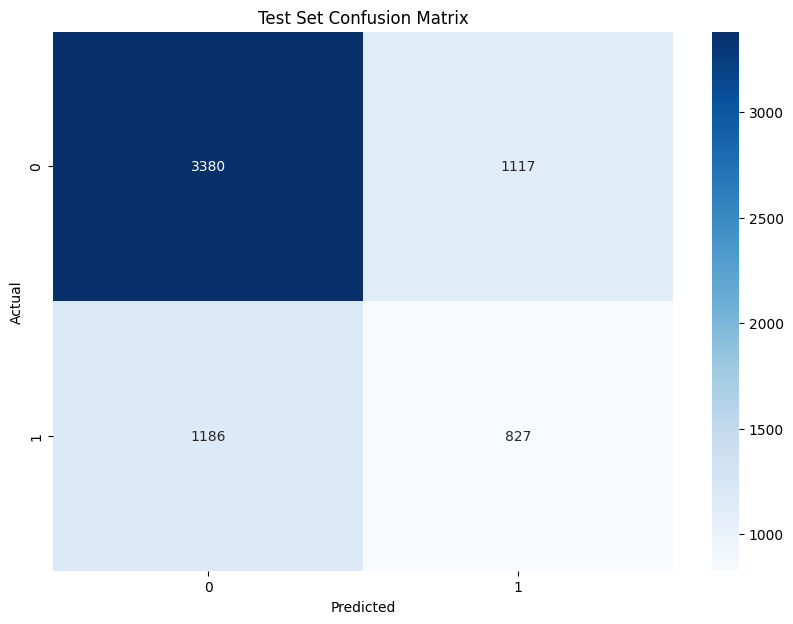

In [ ]:
# Generate confusion matrix for the test set
test_conf_matrix = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(test_conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Test Set Confusion Matrix")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
# Fit the model
model.fit(X_train, y_train)

# Get the logistic regression step from the pipeline
logreg = model.named_steps['model']

# Get the preprocessor step from the pipeline
preprocessor = model.named_steps['preprocessor']

# Get the feature names after preprocessing
feature_names = (preprocessor.transformers_[0][2] + 
                 preprocessor.transformers_[1][2] + 
                 list(preprocessor.named_transformers_['nom'].get_feature_names_out(nominal_cols)))

# Get the coefficients from the logistic regression model
coefficients = logreg.coef_[0]

# Create a DataFrame of feature names and coefficients
feature_importances = pd.DataFrame({'feature': feature_names, 'coefficient': coefficients})

# Sort the DataFrame by the absolute value of the coefficients
feature_importances = feature_importances.reindex(feature_importances.coefficient.abs().sort_values(ascending=False).index)

# Print the feature importances
print(feature_importances)

                             feature  coefficient
13                   code_module_GGG    -1.076493
9                    code_module_CCC     0.975591
35           most_freq_activity_NULL     0.961044
10                   code_module_DDD     0.481408
11                   code_module_EEE    -0.405342
7                    code_module_AAA    -0.377865
22                    region_Ireland    -0.355448
6               num_of_prev_attempts    -0.354505
41   most_freq_activity_htmlactivity     0.343594
2                   early_engagement    -0.323691
46           most_freq_activity_quiz    -0.313920
43      most_freq_activity_oucontent    -0.302314
0                    studied_credits     0.298436
30                      region_Wales    -0.292433
38        most_freq_activity_forumng    -0.287306
33                      disability_N    -0.244914
49            most_freq_activity_url    -0.237069
47       most_freq_activity_resource    -0.227673
19                          gender_M    -0.205569


AUC:  0.736699556065472


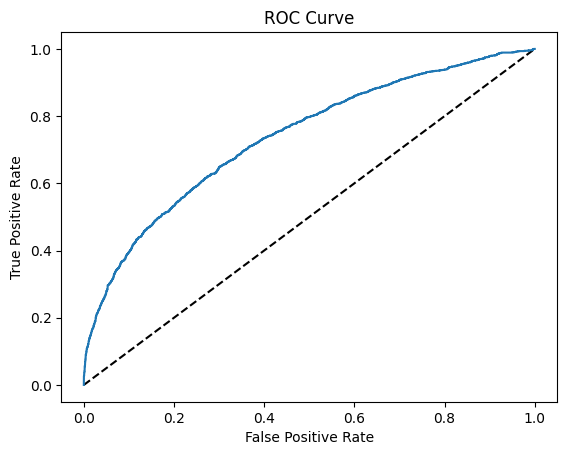

In [ ]:
# Compute predicted probabilities
y_pred_prob = model.predict_proba(X_test)[:, 1]

# Compute and print AUC score
print("AUC: ", roc_auc_score(y_test, y_pred_prob))

# Compute and plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

### Gradient Boosting Classifier

In [ ]:
# Define categorical variables
nominal_cols = ['code_module', 'code_presentation', 'gender', 'region', 'disability', 'most_freq_activity', 'module_presentation_length']
ordinal_cols = ['highest_education', 'imd_band', 'age_band', 'num_of_prev_attempts']
numerical_cols = ['studied_credits', 'date_registration', 'early_engagement']

threshold = 0.6  # adjust this to find the best balance between precision and recall

# Define preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),  
        ('ord', OrdinalEncoder(), ordinal_cols),
        ('nom', OneHotEncoder(handle_unknown='ignore'), nominal_cols)
    ])

# Define pipeline with feature engineering and GBC
# Define pipeline with feature engineering and GBC
model = imPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),  # SMOTE inside pipeline
    ('classifier', GradientBoostingClassifier(n_estimators=5000, random_state=42, learning_rate=0.1, max_depth=5))
])


# Define target variable and features
y = df['withdrawn']
X = df.drop('withdrawn', axis=1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the model
model.fit(X_train, y_train)

# Predict the probabilities of the positive class for the training set
y_train_pred_prob = model.predict_proba(X_train)[:, 1]

# Classify the instances based on the decision threshold
y_train_pred = (y_train_pred_prob > threshold).astype(int)

# Evaluate the model on the training set
print("Training Set Performance:")
print(classification_report(y_train, y_train_pred))

# Predict the probabilities of the positive class
y_pred_prob = model.predict_proba(X_test)[:, 1]

# Classify the instances based on the decision threshold
y_pred = (y_pred_prob > threshold).astype(int)

# Evaluate the model on the test set
print("Test Set Performance:")
print(classification_report(y_test, y_pred))

print("Accuracy Score:")
print(accuracy_score(y_test, y_pred))

print("----------------------------------------")

print("F1 Score:")  # Changed print statement to reflect F1 score
print(f1_score(y_test, y_pred, average='macro'))  # Calculate F1 score on test set

# Define the number of folds for cross-validation
cv = StratifiedKFold(n_splits=5)

# Perform cross-validation on the model
scores = cross_val_score(model, X, y, cv=cv, scoring='f1_macro')

print("----------------------------------------")

# Print the cross-validation scores
print("Cross-validation F1 scores:", scores)

print("----------------------------------------")

# Print the mean and standard deviation of the cross-validation scores
print("Mean cross-validation F1 score:", scores.mean())
print("Standard deviation of cross-validation F1 score:", scores.std())


Training Set Performance:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     17934
           1       1.00      0.98      0.99      8104

    accuracy                           0.99     26038
   macro avg       0.99      0.99      0.99     26038
weighted avg       0.99      0.99      0.99     26038

Test Set Performance:
              precision    recall  f1-score   support

           0       0.76      0.88      0.82      4497
           1       0.60      0.39      0.47      2013

    accuracy                           0.73      6510
   macro avg       0.68      0.64      0.64      6510
weighted avg       0.71      0.73      0.71      6510

Accuracy Score:
0.7302611367127496
----------------------------------------
F1 Score:
0.6447450070954288


KeyboardInterrupt: 

AUC:  0.7052349631774166


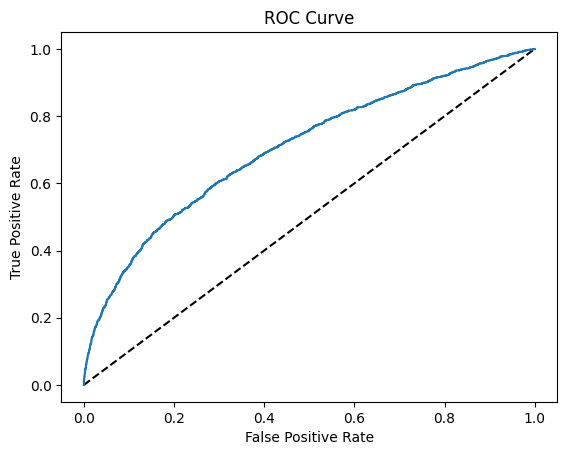

In [ ]:
# Compute predicted probabilities
y_pred_prob = model.predict_proba(X_test)[:, 1]

# Compute and print AUC score
print("AUC: ", roc_auc_score(y_test, y_pred_prob))

# Compute and plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

### Random Forest

In [ ]:
# Define categorical variables
nominal_cols = ['code_module', 'code_presentation', 'gender', 'region', 'disability', 'most_freq_activity', 'module_presentation_length']
ordinal_cols = ['highest_education', 'imd_band', 'age_band', 'num_of_prev_attempts']
numerical_cols = ['studied_credits', 'date_registration', 'early_engagement']

threshold = 0.7  # adjust this to find the best balance between precision and recall


# Define pipeline with feature engineering and GBC
model = imPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),  # SMOTE inside pipeline
    ('classifier', RandomForestClassifier(n_estimators=5000, random_state=42,))
])

# Define target variable and features
y = df['withdrawn']
X = df.drop('withdrawn', axis=1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the model
model.fit(X_train, y_train)

# Predict the probabilities of the positive class for the training set
y_train_pred_prob = model.predict_proba(X_train)[:, 1]

# Classify the instances based on the decision threshold
y_train_pred = (y_train_pred_prob > threshold).astype(int)

# Evaluate the model on the training set
print("Training Set Performance:")
print(classification_report(y_train, y_train_pred))

# Predict the probabilities of the positive class
y_pred_prob = model.predict_proba(X_test)[:, 1]

# Classify the instances based on the decision threshold
y_pred = (y_pred_prob > threshold).astype(int)

# Evaluate the model on the test set
print("Test Set Performance:")
print(classification_report(y_test, y_pred))

print("Accuracy Score:")
print(accuracy_score(y_test, y_pred))

print("----------------------------------------")

print("F1 Score:")  # Changed print statement to reflect F1 score
print(f1_score(y_test, y_pred, average='macro'))  # Calculate F1 score on test set

# Define the number of folds for cross-validation
cv = StratifiedKFold(n_splits=5)

# Perform cross-validation on the model
scores = cross_val_score(model, X, y, cv=cv, scoring='f1_macro')

print("----------------------------------------")

# Print the cross-validation scores
print("Cross-validation F1 scores:", scores)

print("----------------------------------------")

# Print the mean and standard deviation of the cross-validation scores
print("Mean cross-validation F1 score:", scores.mean())
print("Standard deviation of cross-validation F1 score:", scores.std())


Training Set Performance:
              precision    recall  f1-score   support

           0       0.90      1.00      0.94     17934
           1       0.99      0.75      0.85      8104

    accuracy                           0.92     26038
   macro avg       0.95      0.87      0.90     26038
weighted avg       0.93      0.92      0.92     26038

Test Set Performance:
              precision    recall  f1-score   support

           0       0.73      0.93      0.82      4497
           1       0.60      0.22      0.32      2013

    accuracy                           0.71      6510
   macro avg       0.66      0.58      0.57      6510
weighted avg       0.69      0.71      0.67      6510

Accuracy Score:
0.7130568356374808
F1 Score:
0.5707883598100224


### Decision Trees

In [ ]:
# Define categorical variables
nominal_cols = ['code_module', 'code_presentation', 'gender', 'region', 'disability', 'most_freq_activity', 'module_presentation_length']
ordinal_cols = ['highest_education', 'imd_band', 'age_band', 'num_of_prev_attempts']
numerical_cols = ['studied_credits', 'date_registration', 'early_engagement']

threshold = 0.7  # adjust this to find the best balance between precision and recall

# Define preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('ord', OrdinalEncoder(), ordinal_cols),
        ('nom', OneHotEncoder(handle_unknown='ignore'), nominal_cols)
    ])

# Define pipeline with feature engineering and Decision Tree
model = imPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),  # SMOTE inside pipeline
    ('classifier',DecisionTreeClassifier(random_state=42))  # Decision Tree instead of Random Forest
])

# Define target variable and features
y = df['withdrawn']
X = df.drop('withdrawn', axis=1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the model
model.fit(X_train, y_train)

# Predict the probabilities of the positive class for the training set
y_train_pred_prob = model.predict_proba(X_train)[:, 1]

# Classify the instances based on the decision threshold
y_train_pred = (y_train_pred_prob > threshold).astype(int)

# Evaluate the model on the training set
print("Training Set Performance:")
print(classification_report(y_train, y_train_pred))

# Predict the probabilities of the positive class
y_pred_prob = model.predict_proba(X_test)[:, 1]

# Classify the instances based on the decision threshold
y_pred = (y_pred_prob > threshold).astype(int)

# Evaluate the model on the test set
print("Test Set Performance:")
print(classification_report(y_test, y_pred))

print("Accuracy Score:")
print(accuracy_score(y_test, y_pred))

print("----------------------------------------")

print("F1 Score:")  # Changed print statement to reflect F1 score
print(f1_score(y_test, y_pred, average='macro'))  # Calculate F1 score on test set

# Define the number of folds for cross-validation
cv = StratifiedKFold(n_splits=5)

# Perform cross-validation on the model
scores = cross_val_score(model, X, y, cv=cv, scoring='f1_macro')

print("----------------------------------------")

# Print the cross-validation scores
print("Cross-validation F1 scores:", scores)

print("----------------------------------------")

# Print the mean and standard deviation of the cross-validation scores
print("Mean cross-validation F1 score:", scores.mean())
print("Standard deviation of cross-validation F1 score:", scores.std())

Training Set Performance:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     17934
           1       0.99      0.87      0.93      8104

    accuracy                           0.96     26038
   macro avg       0.97      0.93      0.95     26038
weighted avg       0.96      0.96      0.96     26038

Test Set Performance:
              precision    recall  f1-score   support

           0       0.74      0.75      0.75      4497
           1       0.43      0.41      0.42      2013

    accuracy                           0.65      6510
   macro avg       0.58      0.58      0.58      6510
weighted avg       0.64      0.65      0.64      6510

Accuracy Score:
0.6468509984639017
----------------------------------------
F1 Score:
0.5814713131132747
----------------------------------------
Cross-validation F1 scores: [0.57107501 0.3087092  0.37210851 0.38123909 0.46283746]
----------------------------------------
Mean cross-validation F1 s

### Support Vector Machines

In [ ]:
# Define categorical variables
nominal_cols = ['code_module', 'code_presentation', 'gender', 'region', 'disability', 'most_freq_activity', 'module_presentation_length']
ordinal_cols = ['highest_education', 'imd_band', 'age_band', 'num_of_prev_attempts']
numerical_cols = ['studied_credits', 'date_registration', 'early_engagement']

threshold = 0.6  # adjust this to find the best balance between precision and recall

# Define preprocessor
# Define pipeline with feature engineering and Support Vector Machine
model = imPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', SVC(probability=True, random_state=42))  
])
X = df.drop('withdrawn', axis=1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the model
model.fit(X_train, y_train)

# Predict the probabilities of the positive class for the training set
y_train_pred_prob = model.predict_proba(X_train)[:, 1]

# Classify the instances based on the decision threshold
y_train_pred = (y_train_pred_prob > threshold).astype(int)

# Evaluate the model on the training set
print("Training Set Performance:")
print(classification_report(y_train, y_train_pred))

# Predict the probabilities of the positive class
y_pred_prob = model.predict_proba(X_test)[:, 1]

# Classify the instances based on the decision threshold
y_pred = (y_pred_prob > threshold).astype(int)

# Evaluate the model on the test set
print("Test Set Performance:")
print(classification_report(y_test, y_pred))

print("Accuracy Score:")
print(accuracy_score(y_test, y_pred))

print("----------------------------------------")

print("F1 Score:")  # Changed print statement to reflect F1 score
print(f1_score(y_test, y_pred, average='macro'))  # Calculate F1 score on test set

# Define the number of folds for cross-validation
cv = StratifiedKFold(n_splits=5)

# Perform cross-validation on the model
scores = cross_val_score(model, X, y, cv=cv, scoring='f1_macro')

print("----------------------------------------")

# Print the cross-validation scores
print("Cross-validation F1 scores:", scores)

print("----------------------------------------")

# Print the mean and standard deviation of the cross-validation scores
print("Mean cross-validation F1 score:", scores.mean())
print("Standard deviation of cross-validation F1 score:", scores.std())

Training Set Performance:
              precision    recall  f1-score   support

           0       0.80      0.82      0.81     17934
           1       0.58      0.54      0.56      8104

    accuracy                           0.73     26038
   macro avg       0.69      0.68      0.68     26038
weighted avg       0.73      0.73      0.73     26038

Test Set Performance:
              precision    recall  f1-score   support

           0       0.79      0.83      0.81      4497
           1       0.58      0.52      0.55      2013

    accuracy                           0.74      6510
   macro avg       0.69      0.68      0.68      6510
weighted avg       0.73      0.74      0.73      6510

Accuracy Score:
0.7350230414746544
----------------------------------------
F1 Score:
0.6806112582458809
